*Francisco Javier Sáez Maldonado*

Cuaderno de trabajo en el examen de Procesos estocásticos en tiempo continuo.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import stochastic_plots as stoch
import exam as pe
import BM_simulators as simu
import sde_solvers as sde
from collections import Counter
from operator import itemgetter


# Author of the exam: <alberto.suarez@uam.es>
# Exam done by <fjaviersaezm@mail.com>


# Ejercicio 1

## Apartado g

Simula trayectorias del proceso suponiendo que en el instante t = 0, el sistema se encuentra en el estado $P(t = 0) = P_1$.

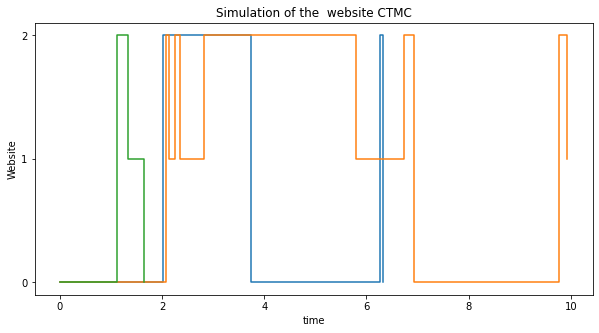

In [2]:
# Define the transition matrix
transition_matrix = [[ 0.0, 0.2, 0.8], 
                     [ 0.3, 0.0, 0.7],
                     [0.6, 0.4, 0.0]]

# Define the lambda rates 
lambda_rates = [0.5, 2.0, 1.0]
N_states = len(lambda_rates)

# Initial constants
t0 = 0.0
t1 = 10.0
state_0 = 0

# Simulate and plot a trajectory.
M = 3 # Number of simulations


# Obtain arrival times and trajectories
arrival_times_CTMC, trajectories_CTMC = (
     pe.simulate_continuous_time_Markov_Chain(
     transition_matrix, lambda_rates, 
     state_0, M, t0, t1))

fig, ax = plt.subplots(1, 1, figsize=(10,5), num=1)

for i in range(M):
    ax.step(arrival_times_CTMC[i], 
             trajectories_CTMC[i],
             where='post')

ax.set_ylabel('Website')
ax.set_xlabel('time')
plt.yticks(np.arange(0,3,1))
_ = ax.set_title('Simulation of the  website CTMC')



## Apartado h

En este apartado, debemos realizar estimaciones sobre distribuciones estacionarias. En la simulación cuando se inicia el sistema desde un estado inicial, supondremos que este sistema tarda un número de iteraciones hasta "normalizar" el estado de ese sistema. Es por ello que, para hacer la estimación, eliminaremos las $n\_remove$ primeras posiciones de los vectores para no tener en cuenta estos valores. Debido a que solo tenemos 3 estados, eliminaremos únicamente las primeras $20$ posiciones.

**i)** Estimamos la distribución estacionaria del proceso de saltos subyacente a partir de una única trayectoria (suficientemente larga) de la CTMC.

Para ello, simulamos esta trayectoria y obtenemos las probabilidades empíricas de estar en cada estado.

In [3]:
# Stationary distribution of the jump process from a single trajectory

n_remove = 20 #numbers of positions to remove
M = 1 # Number of simulations
N_webs = 3 # Number of webs
long_t = 100000.0 # Time steps per simulation
arrival_times_CTMC, trajectories_CTMC = (
     pe.simulate_continuous_time_Markov_Chain(
     transition_matrix, lambda_rates, 
     state_0, M, t0, long_t))

# Separate trajectory
traj = trajectories_CTMC[0][n_remove:]

# Count the frequency and sort the order
counts = Counter(traj)
counts = sorted(counts.items(), key=itemgetter(0))

# Empirical probabilities
probs = np.array([counts[i][1] for i in range(N_webs)])/len(traj)

# Vector of theoretical probabilities in the jump process
theo_jump = np.array([36/109, 26/109, 47/109])

print("Stationary distribution of the jump chain")
print("\t Theoretical: {}".format(theo_jump))
print("\t Empirical:   {}".format(probs))

Stationary distribution of the jump chain
	 Theoretical: [0.33027523 0.23853211 0.43119266]
	 Empirical:   [0.33141096 0.23699387 0.43159517]


Como podemos observar, obtenemos un valor aproximado razonablemente bien al valor teórico de la distribución estacionaria del proceso de saltos.

**ii)** Queremos ahora estimar la distribución estacionaria de la CTMC a partir de una única trayectoria.

Para ello, usaremos la misma simulación anterior (aunque podría simularse de nuevo) para contar cuánto tiempo (empírico) se pasa en cada estado, sumamos el tiempo total en cada estado y dividimos por el tiempo total.

In [4]:
# Stationary distribution of the CTMC from a single trajectory
# Get times of the jumps
times = arrival_times_CTMC[0][n_remove:]

# Initialize times in each state
times_i = np.array([0.0,0.0,0.0])

# Sum in each state the time spent in that state
for i in range(1,len(times)):
    times_i[traj[i-1]] += times[i] - times[i-1]
    
#Obtain probabilities
estimated_ctmc = times_i/long_t
# Vector of the theoretical stationary distribution
theo_ctmc = np.array([72/132, 13/132, 47/132])

print("Stationary distribution of the CTMC")
print("\t Theoretical: {}".format(theo_ctmc))
print("\t Empirical:   {}".format(estimated_ctmc))

Stationary distribution of the CTMC
	 Theoretical: [0.54545455 0.09848485 0.35606061]
	 Empirical:   [0.54182817 0.09894246 0.35884014]


Vemos como se aproxima con bastante precisión también la distribución estacionaria de la CTMC utilizando una única trayectoria. Por supuesto, se podrían simular un número $n \in \mathbb N$ de trayectorias y promediar, para reducir la varianza.

**iii)** Vamos a estimar la distribución de la CTMC cuando $t \to \infty$ a partir de los estados finales en $M = 1000$ trayectorias simuladas.

In [5]:
# Stationary distribution of the CTMC from the final state in a sample of M trajectories
# Simulate and plot a trajectory.
M = 1000 # Number of simulations
t1 = 1000.0 # Final time
arrival_times_CTMC, trajectories_CTMC = (
     pe.simulate_continuous_time_Markov_Chain(
     transition_matrix, lambda_rates, 
     state_0, M, t0, t1))

#Obtain final states
final_states = [traj[-1] for traj in trajectories_CTMC]

# Count and sort 
counts = Counter(final_states)
counts = sorted(counts.items(), key=itemgetter(0))

# Obtain probabilities
probs = np.array([counts[i][1] for i in range(3)])/M

print("Empirical distribution of CTMC chain {}".format(probs))

Empirical distribution of CTMC chain [0.551 0.105 0.344]


Se puede observar que es bastante más probable que el usuario esté en la página web $P_1$, luego en la $P_3$ y luego en la $P_2$, independientemente del estado inicial. Esto tiene sentido, pues mirando el diagrama de transiciones vemos que 

- Desde $P_1$, es mucho más probable que salte hacia $P_3$ que hacia $P_2$.

- También desde el estado $P_3$, es un $20\%$ más probable que salte a $P_1$ que que salte a $P_2$.

Por estas dos razones, es muy probable que se pueda repetir un gran número de veces el ciclo $P_1 \to P_3 \to P_1$, haciendo que sea así el estado $P_1$ visitado más veces que el resto.

# Ejercicio 2

## Apartado g

Suponemos que $r_\infty = 5\%$, $\alpha = 2$ , $r_0 = 10\%$, simulamos $M = 1000$ trayectorias. Consideramos $\sigma = 1.0$ ya que no se indica nada sobre este parámetro.

Se nos indica un $\tau_{\alpha}$, que no lo tenemos definido hasta ahora, así que entendemos $\alpha = \tau_{\alpha}$

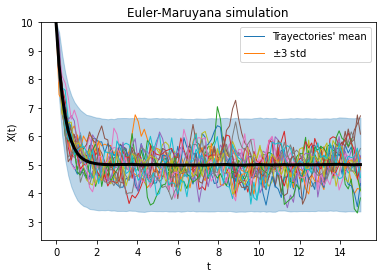

In [6]:
# Simulation of a sample of trajectories

alpha = 2.0
r_infty = 5.0
r_0 = 10.0
sigma = 1.0

M = 10000
t0 = 0.0
T = 15.0
N = 100

a = lambda t,x: -alpha*(x - r_infty)
b = lambda t,x: sigma

ts_eu,S_eu = pe.euler_maruyana(t0,r_0,T,a,b,M,N)

y_max = min(np.max(S_eu), 3000)


stoch.plot_trajectories(ts_eu, S_eu, fig_num=1)

sde.subplot_mean_and_std(ts_eu, np.mean(S_eu, axis=0),
                         3*np.std(S_eu, axis=0), # 99% is 3 times std
                         ylims=[np.min(S_eu), y_max],
                         color='black')
plt.legend(['Trayectories\' mean', '$\pm$3 std'])
_ = plt.title('Euler-Maruyana simulation')

Simulamos ahora usando Milstein. En este caso, tenemos que la derivada de $b(t,x)$ respecto de $x$ es cero, por lo que simplemente lo definimos y llamamos al método que teníamos.

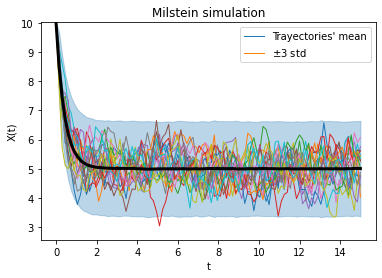

In [7]:
db_dx = lambda t,x: 0

ts_mil, S_mil = pe.milstein(t0,r_0,T,a,b,db_dx,M,N)   


y_max = min(np.max(S_mil), 3000)


stoch.plot_trajectories(ts_mil, S_mil, fig_num=1)

sde.subplot_mean_and_std(ts_mil, np.mean(S_mil, axis=0),
                         3*np.std(S_mil, axis=0), # 99% is 3 times std
                         ylims=[np.min(S_mil), y_max],
                         color='black')
plt.legend(['Trayectories\' mean', '$\pm$3 std'])
_ = plt.title('Milstein simulation')

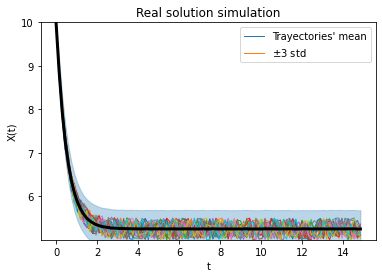

In [8]:

# Generate the Z variable
Z = np.random.rand(M,N)
# Generate times
ts = pe.generate_regular_grid(t0,T/N,N-1)

# Define real t function
def r(t,random):
    return r_infty + (r_0 - r_infty)*np.exp(-alpha*(t-t0))  + \
        sigma*np.sqrt((1 - np.exp(-2*alpha*(t-t0)))/(2*alpha))*random

# Compute trajectories using the Z and the r function
Rs = np.array([
    [
        r(ti,random) for ti,random in zip(ts,Z[i])
    ]
    for i in range(Z.shape[0])
])

#Plot
y_max = min(np.max(Rs), r_0)

stoch.plot_trajectories(ts, Rs, fig_num=1)

sde.subplot_mean_and_std(ts, np.mean(Rs, axis=0),
                         3*np.std(Rs, axis=0), # 99% is 3 times std
                         ylims=[np.min(Rs), y_max],
                         color='black')
plt.legend(['Trayectories\' mean', '$\pm$3 std'])
_ = plt.title('Real solution simulation')

## Apartado h

Usando las simulaciones, queremos comparar gráficamente las estimaciones muestrales de la media y la desviación estándar de $r(t)$.


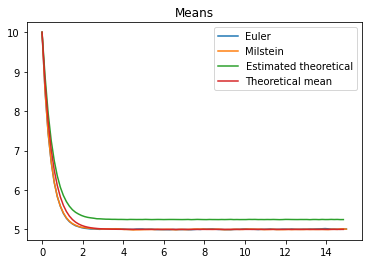

In [9]:
def theo_mean(t):
    return r_infty + (r_0 - r_infty)*np.exp(-alpha*(t-t0))

plt.plot(ts_eu,np.mean(S_eu,axis=0), label="Euler")
plt.plot(ts_mil,np.mean(S_mil,axis=0), label="Milstein")
plt.plot(ts, np.mean(Rs,axis = 0), label = "Estimated theoretical")
plt.plot(ts,theo_mean(ts),label="Theoretical mean")
plt.title("Means")
plt.legend()
plt.show()

Se puede observar que, en este caso, la media 
Lo realizamos ahora con las desviaciones estándar:

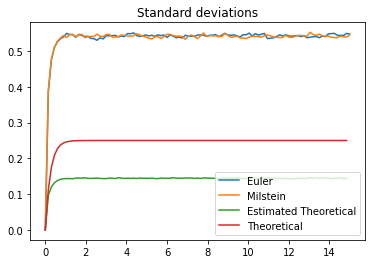

In [10]:
def theo_std(t):
    return (sigma**2)*(1-np.exp(-2*alpha*(t-t0)))/(2*alpha)


plt.plot(ts_eu,np.std(S_eu,axis=0), label="Euler")
plt.plot(ts_mil,np.std(S_mil,axis=0), label="Milstein")
plt.plot(ts, np.std(Rs,axis = 0), label = "Estimated Theoretical")
plt.plot(ts, theo_std(ts),label = "Theoretical")
plt.title("Standard deviations")
plt.legend()
plt.show()

## Apartado i

In [11]:
def move(t):
    return np.sqrt((1-np.exp(-2*alpha*(t-t0)))/(2*alpha))

def cov(t1,t2):
    return sigma*sigma*move(t1)*move(t2)

def gamma(t,tau):
    return cov(t+tau,t)

def rho(tau):
    return gamma(tau)/gamma(0)


## Apartado j

Vamos a dibujar lo que se nos pide en este apartado. Podemos considerar cualquier método, pero hemos visto en teoría que el mejor método es el Milstein, por lo que usaremos estas simulaciones.

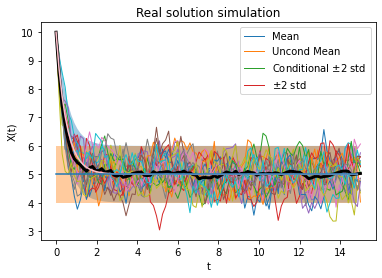

In [12]:

mean = np.array([r_infty + (r_0 - r_infty)*np.exp(-alpha*(t-t0)) for t in ts])
std = np.array([sigma/np.sqrt(2*alpha) * np.sqrt(1 - np.exp(-2*alpha*(t - t0))) for t in ts])
uncond_mean = np.repeat(r_infty, len(ts))
uncond_std = np.repeat(sigma/np.sqrt(2*alpha), len(ts))

stoch.plot_trajectories(ts_mil, S_mil[0:50], fig_num=1)
plt.plot(ts, mean, color = 'pink')
plt.plot(ts, uncond_mean)
plt.fill_between(ts, mean-2*std,
                 mean+2*std
                 , alpha=0.4)
plt.fill_between(ts, uncond_mean-2*uncond_std,
                 uncond_mean+2*uncond_std
                 , alpha=0.4)
plt.legend(["m"])
plt.legend(['Mean', 'Uncond Mean', 'Conditional $\pm$2 std', '$\pm$2 std'])
_ = plt.title('Real solution simulation')

Vemos como la media de las trayectorias está bastante cercana (aún usando solo 50 trayectorias) a la media incondicional, y además las trayectorias tienden a la media estacionaria, encontrándose en su mayoría en $\pm 2$ desviaciones típicas.

## Apartado K

Consultamos la web del [euribor](https://datosmacro.expansion.com/hipotecas/euribor) y se nos da que:

- $r_0 = -0.502$
- $\sigma = -0.005$
- No encontramos la tasa de reversión a la media $\alpha$, usamos 1
- Consideramos que $r_0 = r_\infty$

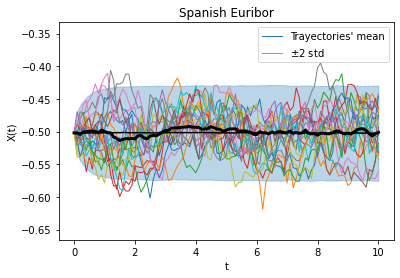

In [13]:
alpha = 1.0
r_0 = -0.502
r_infty = r_0
T = 10
sigma = -0.05

M = 10000
t0 = 0.0
N = 100

db_dx = lambda t,x: 0

ts_mil, S_mil = pe.milstein(t0,r_0,T,a,b,db_dx,M,N)   


y_max = min(np.max(S_mil), 3000)


stoch.plot_trajectories(ts_mil, S_mil[0:50], fig_num=1)

sde.subplot_mean_and_std(ts_mil, np.mean(S_mil, axis=0),
                         2*np.std(S_mil, axis=0), # 99% is 3 times std
                         ylims=[np.min(S_mil), y_max],
                         color='black')
plt.legend(['Trayectories\' mean', '$\pm$2 std'])
_ = plt.title('Spanish Euribor')

## Apartado l

Comentamos los resultados:

- La tasa de reversión a la media es que no importa en qué tiempo estemos o en qué valor del proceso estemos, siempre volvemos a pasar por la meida

- La escala se observa en un tiempo bastante corto, de normalmente menos de 1 año

- El proceso es estacionario si tenemos un valor del proceso al que tendemos y cuando llegamos a él no tenemos mucha variación

- Sí es estacionario, pues los valores del proceso del Euribor están variando en el intervalo $[-0.55,-0.45]$ todo el tiempo de aquí a $10$ años, por lo que consideramos que es estacionario.

- El tiempo es de menos de un año, pues tardamos muy poquito en estabilizarnos y que la desviación típica crezca bastante.

- Es la misma escala, pues tenemos que en ambos es aproximadamente un año lo que tarda en volver a la media y también la escala del régimen transitorio.